
### <font color='Brown'> I. Setting the Working Enviornment

In [2]:
!pip install pyLDAvis
import pyLDAvis # package to interpret the topics in a topic model
import pyLDAvis.gensim_models # python library for the interactive topic modeling visualization
import pickle # for html export
import pandas as pd # for data processing
import os # for setting working directory
import re # regular expression library
from wordcloud import WordCloud # for generating word clouds
import gensim # open-source library for unsupervised topic modeling, document indexing
from gensim.utils import simple_preprocess
import nltk # python tool kit for NLP
nltk.download('stopwords')
from nltk.corpus import stopwords # for removing stop words
import gensim.corpora as corpora # for mapping words to integers
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### <font color='Brown'> II. Importing Data

In this session, we will be using the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016.

In [3]:
# Master Folder Path
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks
!ls


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
amazon_alexa.tsv  papers.csv  SentimentAnalysis_wellbe.ipynb  Topic_modeling.ipynb


In [4]:
papers = pd.read_csv('papers.csv')
# in case using local directory
#master_path = R"C:\Users\arpendu.ganguly\OneDrive - Accenture\2021_DELL_ALL_Backup\01_G_SELF\G_Analytics Vidhya Data Hour"
#papers = pd.read_csv(os.path.join(master_path,"01_Input_Data",'papers.csv'))
print("The shape of data --->",papers.shape)
papers.head(10) # Print head

The shape of data ---> (6560, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


## Initial Pre-Processing Data
Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 200 papers. For Pre-processing, we are performing:

- removing any punctuation
- lowercase conversion

In [5]:
# Remove the columns
sample_text = 200
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(sample_text)

##### Remove punctuation/lower casing
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

2221    stratification learning: detecting mixed densi...
596     independent component analysis of\nintracellul...
4275    simulation of optimal movements using the\nmin...
2142    estimation of intrinsic dimensionality using\n...
4784    clustering from labels and time-varying graphs...
Name: paper_text_processed, dtype: object

###  <font color='Brown'> IV. Exploratory Data Analysis on the Text Data - WORD CLOUD Generation
To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

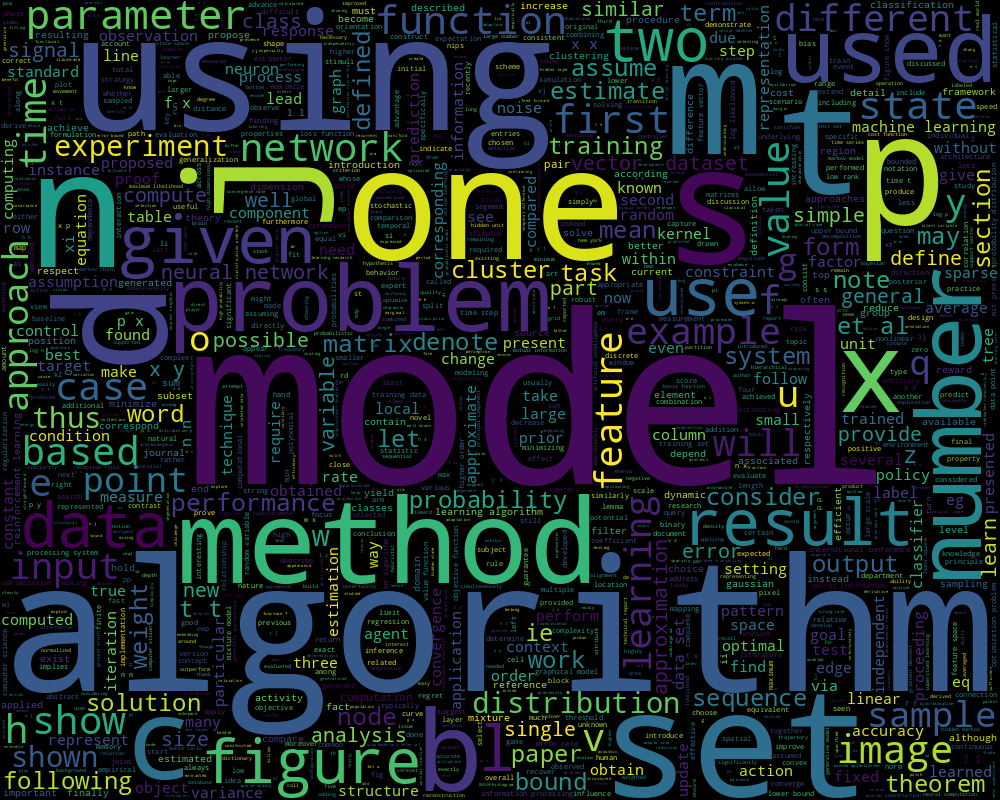

In [6]:
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue',width=1000,height=800)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### <font color='Brown'> V. Initating the LDA Analysis
Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'used','using','use','model','one','two','set'])
"""
    Functions for converting sentence to words
"""
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
"""
    Functions removing the stopwords
"""
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()#creating the array of token
data_words = list(sent_to_words(data))#converting them into list

data_words = remove_stopwords(data_words)# remove stop words
print(data_words[:1][0][:30])

['stratification', 'learning', 'detecting', 'mixed', 'density', 'dimensionality', 'high', 'dimensional', 'point', 'clouds', 'gloria', 'haro', 'gregory', 'randall', 'guillermo', 'sapiro', 'ima', 'electrical', 'computer', 'engineering', 'university', 'minnesota', 'minneapolis', 'mn', 'haro', 'fingeduuyguille', 'umnedu', 'abstract', 'study', 'point']


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 11), (4, 1), (5, 2), (6, 3), (7, 1), (8, 2), (9, 1), (10, 1), (11, 2), (12, 3), (13, 2), (14, 4), (15, 1), (16, 1), (17, 2), (18, 1), (19, 17), (20, 1), (21, 1), (22, 2), (23, 2), (24, 9), (25, 3), (26, 2), (27, 3), (28, 3), (29, 1)]


In [9]:
#Showing the code
id2word

###  <font color='Brown'> VI. LDA model tranining
Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [10]:
from pprint import pprint
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics, so print the words associated to each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"learning" + 0.007*"data" + 0.006*"algorithm" + 0.004*"function" + '
  '0.003*"given" + 0.003*"error" + 0.003*"time" + 0.003*"state" + '
  '0.003*"problem" + 0.003*"number"'),
 (1,
  '0.006*"data" + 0.006*"learning" + 0.005*"algorithm" + 0.004*"function" + '
  '0.003*"number" + 0.003*"time" + 0.003*"method" + 0.003*"figure" + '
  '0.003*"based" + 0.003*"results"'),
 (2,
  '0.007*"learning" + 0.006*"algorithm" + 0.005*"data" + 0.004*"time" + '
  '0.004*"function" + 0.004*"problem" + 0.003*"based" + 0.003*"number" + '
  '0.003*"also" + 0.003*"figure"'),
 (3,
  '0.008*"learning" + 0.006*"algorithm" + 0.005*"data" + 0.005*"function" + '
  '0.004*"time" + 0.003*"matrix" + 0.003*"given" + 0.003*"problem" + '
  '0.003*"figure" + 0.003*"number"'),
 (4,
  '0.006*"data" + 0.005*"learning" + 0.004*"time" + 0.004*"algorithm" + '
  '0.004*"number" + 0.003*"first" + 0.003*"problem" + 0.003*"figure" + '
  '0.003*"function" + 0.003*"also"'),
 (5,
  '0.005*"data" + 0.005*"learning" + 0.00

###  <font color='Brown'> VII. Analysing the LDA Model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.o transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [13]:
master_path= r'/content/drive/MyDrive/Colab Notebooks'
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(master_path,'ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared,'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.008807 -0.000121       1        1  14.001528
8     -0.002640  0.009701       2        1  13.246933
0      0.004428  0.000027       3        1  12.493721
2     -0.000967 -0.002509       4        1  12.219536
4      0.000731  0.000387       5        1  11.665687
1     -0.003374 -0.001103       6        1  10.210387
9     -0.001343 -0.001367       7        1   9.987266
7      0.000562  0.002638       8        1   7.780675
3      0.001546 -0.004572       9        1   7.309017
5     -0.007749 -0.003081      10        1   1.085250, topic_info=           Term         Freq        Total Category  logprob  loglift
177        data  2415.000000  2415.000000  Default  30.0000  30.0000
450    learning  2892.000000  2892.000000  Default  29.0000  29.0000
19    algorithm  2373.000000  2373.000000  Default  28.0000  28.0000
481      matrix  1158.000000  1158.000000  Default  27.0000  27.0000
788        time  1753.000000  1753.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
747       state    10.529703  1217.013459  Topic10  -6.1341  -0.2266
498      method     9.896251  1049.476307  Topic10  -6.1962  -0.1405
551      number    10.341783  1465.670699  Topic10  -6.1521  -0.4305
299      figure    10.209840  1410.026620  Topic10  -6.1650  -0.4047
881  algorithms     8.805002   941.549476  Topic10  -6.3130  -0.1488

[922 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
16619      4  0.223268  accessesx
16619      5  0.223268  accessesx
3236       1  0.126082     action
3236       2  0.179507     action
3236       3  0.141041     action
...      ...       ...        ...
5422       5  0.127879         zs
5422       6  0.063939         zs
5422       7  0.063939         zs
5422       8  0.063939         zs
5422       9  0.191818         zs

[4373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 1, 3, 5, 2, 10, 8, 4, 6])

In [16]:
from pprint import pprint
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics, so print the words associated to each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"learning" + 0.005*"data" + 0.004*"algorithm" + 0.004*"function" + '
  '0.004*"figure" + 0.003*"models" + 0.003*"based" + 0.003*"training" + '
  '0.003*"time" + 0.003*"given"'),
 (1,
  '0.006*"learning" + 0.006*"data" + 0.005*"algorithm" + 0.005*"time" + '
  '0.004*"function" + 0.003*"based" + 0.003*"problem" + 0.003*"number" + '
  '0.003*"figure" + 0.003*"given"'),
 (2,
  '0.006*"algorithm" + 0.006*"learning" + 0.005*"data" + 0.004*"time" + '
  '0.004*"number" + 0.003*"problem" + 0.003*"network" + 0.003*"function" + '
  '0.003*"models" + 0.003*"state"'),
 (3,
  '0.007*"data" + 0.006*"learning" + 0.005*"algorithm" + 0.004*"time" + '
  '0.003*"function" + 0.003*"figure" + 0.003*"training" + 0.003*"problem" + '
  '0.003*"matrix" + 0.003*"number"'),
 (4,
  '0.006*"learning" + 0.006*"algorithm" + 0.005*"function" + 0.004*"data" + '
  '0.004*"time" + 0.004*"number" + 0.003*"models" + 0.003*"based" + '
  '0.003*"problem" + 0.003*"network"')]


In [17]:
master_path= r'/content/drive/MyDrive/Colab Notebooks'
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(master_path,'ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared,'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.003549  0.003378       1        1  24.522281
2      0.001272 -0.004987       2        1  22.217301
3     -0.006474  0.001306       3        1  19.550865
0      0.000388 -0.002772       4        1  17.274307
1      0.001265  0.003075       5        1  16.435245, topic_info=              Term         Freq        Total Category  logprob  loglift
450       learning  2841.000000  2841.000000  Default  30.0000  30.0000
177           data  2399.000000  2399.000000  Default  29.0000  29.0000
788           time  1725.000000  1725.000000  Default  28.0000  28.0000
2601        sparse   650.000000   650.000000  Default  27.0000  27.0000
384          image   868.000000   868.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
404    information   156.582954   948.914383   Topic5  -6.1523   0.0040
1564        models   171.162848  1262.179413   Topic5  -6.0633  -0.1922
1100         input   144.541315   876.416591   Topic5  -6.2324   0.0035
460         linear   144.769156   938.905023   Topic5  -6.2308  -0.0638
223   distribution   145.019316  1020.052755   Topic5  -6.2291  -0.1450

[455 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
20885      1  0.354827  accv
20885      2  0.354827  accv
20885      4  0.354827  accv
16504      1  0.118481   ace
16504      2  0.236962   ace
...      ...       ...   ...
865        5  0.113334    zt
1370       1  0.208455   zur
1370       2  0.208455   zur
1370       3  0.416911   zur
1370       4  0.208455   zur

[1419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

## Next Steps:

1. Improving the Input Matrix which goes into the Model by using Natural Processing Functions like Lemmatization, Stemming and Pharse Modeling (using bi-gram or tri-gram features)
2. Iterating on different Number of topics to view the quality of topics being created
3. Using Model Perplexity & Coherence Score to decide on the optimal no. of Topics
4. Hyperparamter Tuning of the Model Parameters